# Package functions


**Context**: Clean the notebook by packaging all the functions together.



# Imports


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras.backend as K

# Scaling the data
from sklearn.preprocessing import MinMaxScaler

# Create RNN model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError

# Model selection
from sklearn.model_selection import TimeSeriesSplit

# Functions



## General functions


In [2]:
def merge_dataframes_on_index(df_a : pd.DataFrame, df_b: pd.DataFrame) -> pd.DataFrame:
    '''
    This function receives 2 Pandas dataframes.
    It merges them together based on their index (time-related indexes).
    It returns a merged dataframe.
    '''
    return pd.merge(df_a, df_b, left_index=True, right_index=True)

## Load data functions


In [3]:
def load_stock_data_locally(path:str) -> pd.DataFrame:
    '''
    This function receives a path (string) indicating where the stock data is stored locally.
    - It loads the stock data as csv file.
    - It takes Date column as index.
    - It transforms the index into Date time index.
    It returns it as a Pandas Dataframe.
    '''
    stock = pd.read_csv(path, index_col='Date')
    stock.index = pd.to_datetime(stock.index)
    return stock

## Train and test split functions


In [4]:
def get_split_data(df:pd.DataFrame, train_size : float):
    '''
    This function gets a Pandas Dataframe and an float that represents 
    the size of my train dataset relative to all the available data.
    It return a train dataset and a test dataset.
    '''
    index= round(train_size*df.shape[0])
    train = df.iloc[:index]
    test = df.iloc[index:]
    return train, test

## Plotting train and test data functions



In [5]:
def plot_train_test_df(train:pd.DataFrame, test:pd.DataFrame):
    '''
    This function receives 2 Pandas Dataframes: train and test.
    - It selects the numerical features in the input dataframes.
    - It plots lineplots for each numerical feature of the 2 input dataframes.
    '''     
    # Numerical Features
    numerical_features = train.select_dtypes(include = 'number').columns.values.tolist()

    #Parameters     
    ncol_max = 1
    nrow_max = len(numerical_features)   
    
    #Figure settings
    fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(8, 15))

    # Flatten axes for easy iteration
    axs = axs.flatten()
    
    for index, col in enumerate(numerical_features):  
        # Plotting the histograms
        sns.lineplot(data = train[numerical_features], y= col, x=train.index,  ax=axs[index])   
        sns.lineplot(data = test[numerical_features], y= col, x=test.index,  ax=axs[index])  
        
        # Formatting
        axs[index].set_xlabel(col)
        axs[index].set_title(f'Line Plot - {col}')  
        axs[index].legend(["Train set", "Test set"], title="Legend", loc="best")
        
        # Adjust spacing between subplots
        plt.subplots_adjust(wspace=0.3, hspace=0.8)  # wspace (width), hspace (height)    

In [6]:
def plot_lines_series_train_test(train:pd.DataFrame, test:pd.DataFrame, target):
    '''
    This function receives 2 Pandas Dataframes: train and test, and a target feature.
    - It plots lineplots for each numerical feature of the 2 input dataframes.
    '''      
    #Figure settings
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Plotting the histograms
    sns.lineplot(data=train, x=train.index, y=target)  
    sns.lineplot(data=test, x=test.index, y=target)  
    
    # Formatting  
    ax.set_xlabel(f"{target}")
    ax.set_title(f'Line Plot - {target}')  
    ax.legend(["Train set", "Test set"], title="Legend", loc="best")

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.8)  # wspace (width), hspace (height)     

## Plotting predictions and test data functions

In [7]:
def plot_lines_series_pred_test(pred:pd.DataFrame, test:pd.DataFrame):
    '''
    This function receives 2 Pandas Dataframes: pred and test.
    - It plots lineplots for each numerical feature of the 2 input dataframes.
    '''      
    import matplotlib.dates as mdates
    #Figure settings
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plotting the histograms
    sns.lineplot(data=test, x=test.index, y='y_test')  
    sns.lineplot(data = pred, x=pred.index, y='predictions')  

    
    # Formatting  
    ax.set_xlabel("Date")
    ax.set_title(f'Line Plot')  
    ax.legend(["Test set", "Predictions"], title="Legend", loc="best")

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.8)  # wspace (width), hspace (height)   
   
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format to show 
    
    plt.grid()
    plt.tight_layout()

## Data preparation functions

In [8]:
def prepare_train_data_multiple_feats(df, features_list: list, target:str, scaler, target_scaler, look_back=10):
    '''
    This function receives a Pandas dataframe, a features list, a target feature, a scaler and a observation window parameter.
    - It scales the train data, then create sequences of train data.
    Outputs : training data X, training target y and fitted scaler
    '''
    scaled_data = scaler.fit_transform(df[features_list]) 
    scaled_data_df = pd.DataFrame(scaled_data, columns=scaler.get_feature_names_out())
    
    #Scaling target (for prediction inverse transform)
    target_scaler.fit(df[[target]])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data_df)-1):
        X.append(scaled_data_df.iloc[i-look_back:i].to_numpy())
        y.append(scaled_data_df[target].iloc[i])       
    return np.array(X), np.array(y), scaler, target_scaler

In [9]:
def prepare_test_data_multiple_feats(df, features_list: list, target:str, scaler, look_back=10):
    '''
    This function receives a Pandas dataframe, a target list, a scaler and a observation window parameter.
    Scales the test data, then create sequences of test data.
    Outputs : test data X, test target y and associated dates
    '''
    scaled_data = scaler.transform(df[features_list])
    scaled_data_df = pd.DataFrame(scaled_data, columns=scaler.get_feature_names_out())
    
    X, y = [], []
    dates = []
    for i in range(look_back, len(scaled_data_df)-1):
        X.append(scaled_data_df.iloc[i-look_back:i].to_numpy())
        y.append(scaled_data_df[target].iloc[i]) 
        dates.append(df.index[i])
    return np.array(X), np.array(y), dates

## Model architecture functions

In [10]:
# Create LSTM model architecture
def define_LSTM_model(window, nb_feature):
    '''
    Defines the structure of the deep learning model, then defines compilation parameters.
    Outputs LSTM model instance.
    '''
    # 1- RNN Architecture
    model = Sequential()
    model.add(layers.LSTM(units=50, activation='tanh',return_sequences=True, input_shape=(window,nb_feature)))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.LSTM(units=20, activation='tanh',return_sequences=False))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1, activation="linear"))

    # 2- Compilation
    model.compile(loss='mse', optimizer='adam', 
                  metrics =['mse', 'mae', RootMeanSquaredError(), MeanAbsolutePercentageError()])
    return model

In [11]:
# Create LSTM model architecture (maximize correlation)
def define_LSTM_model_max_correlation(window, nb_feature):
    '''
    Defines the structure of the deep learning model, then defines compilation parameters.
    Outputs LSTM model instance.
    '''
    # 1- RNN Architecture
    model = Sequential()
    model.add(layers.LSTM(units=50, activation='tanh',return_sequences=True, input_shape=(window,nb_feature)))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.LSTM(units=20, activation='tanh',return_sequences=False))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1, activation="linear"))

    # 2- Compilation
    model.compile(loss=pearson_corr_loss, optimizer='adam', 
                  metrics =['mse', 'mae', RootMeanSquaredError(), MeanAbsolutePercentageError()])
    return model

## Model fitting functions

In [12]:
def fit_lstm_model(model, X_train_scaled, y_train_scaled):
    '''
    This function receives an LSTM model, scaled train data and scaled train target (i.e predicted output).
    It returns the fitted LSTM model.
    '''
    # Fitting model parameter
    es = EarlyStopping(patience = 30, restore_best_weights=True)

    # Fitting model
    history = model.fit(x=X_train_scaled,
                        y=y_train_scaled,
                        batch_size=16,
                        epochs=1000,
                        verbose=0,
                        callbacks=[es],
                        validation_split=0.3,
                        shuffle=False)
    return model

## Make predictions functions


In [13]:
def make_predictions(model, fitted_scaler, dates):
    '''
    This function receives an LSTM model,
    a fitted scaler to rebuild/scale back the prediction to actual units, and test dates.
    '''
    # Predictions from unseen data
    y_pred = model.predict(X_test_scaled)
    y_pred = fitted_scaler.inverse_transform(y_pred)   
    y_pred_df = pd.DataFrame(y_pred, index=dates, columns=['predictions'])

    return y_pred_df
    

In [14]:
def compute_y_test(y_test_scaled, fitted_scaler, dates):
    '''
    This function receives the scaled datatest,
    a fitted scaler to rebuild/scale back the test data to actual units, and test dates.
    '''
    # Compute y_test (no scaling)
    y_test_scaled = y_test_scaled.reshape(-1,1)
    y_test = fitted_scaler.inverse_transform(y_test_scaled)
    y_test_df = pd.DataFrame(y_test, index=dates, columns=['y_test'])
    return y_test_df

## Plotting train, test and predictions functions

In [15]:
def plot_final_lstm(train, train_label,
                   test, test_label,
                   forecast_recons, forecast_recons_label,
                   target):
    '''
    Plots the training data, the test data and the predictions from LSTM model.
    Outputs : All the data on left side, a zoomed plot on latest data on the right side.
    '''
    import matplotlib.dates as mdates
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(train, label=train_label)
    axs[0].plot(test, label=test_label)
    axs[0].plot(forecast_recons, label=forecast_recons_label)
    axs[0].legend()
    axs[0].set_title('Train data, test data and predictions')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel(f"{target[0]}")
    axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show 
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format to show 

    n_last =100
    axs[1].plot(train[-n_last:], label=train_label)
    axs[1].plot(test, label=test_label)
    axs[1].plot(forecast_recons, label=forecast_recons_label)
    axs[1].legend()
    axs[1].set_title('ZOOM on train data, test data and predictions')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel(f"{target[0]}")
    axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show 
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format to show 
    plt.tight_layout()

In [16]:
def plot_final_lstm_3windows(train, train_label,
                   test, test_label,
                   forecast_recons, forecast_recons_label,
                   target):
    '''
    Plots the training data, the test data and the predictions from LSTM model.
    Outputs : All the data on left side, a zoomed plot on latest data on the right side.
    '''
    import matplotlib.dates as mdates
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    axs[0].plot(train, label=train_label)
    axs[0].plot(test, label=test_label)
    axs[0].plot(forecast_recons, label=forecast_recons_label)
    axs[0].legend()
    axs[0].set_title('Train data, test data and predictions')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel(f"{target[0]}")
    axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show 
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format to show 

    n_last =100
    axs[1].plot(train[-n_last:], label=train_label)
    axs[1].plot(test, label=test_label)
    axs[1].plot(forecast_recons, label=forecast_recons_label)
    axs[1].legend()
    axs[1].set_title('ZOOM on train data, test data and predictions')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel(f"{target[0]}")
    axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show 
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format to show 
    
    axs[2].plot(test, label=test_label)
    axs[2].plot(forecast_recons, label=forecast_recons_label)
    axs[2].legend()
    axs[2].set_title('Test data and predictions')
    axs[2].set_xlabel('Date')
    axs[2].set_ylabel(f"{target[0]}")
    axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show 
    axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format to show 
    plt.tight_layout()
    

In [17]:
def plot_final_lstm_3windows_tuning(train, train_label,
                   test, test_label,
                   forecast_recons, forecast_recons_label,
                   target, tuple):
    '''
    Plots the training data, the test data and the predictions from LSTM model.
    Outputs : All the data on left side, a zoomed plot on latest data on the right side.
    '''
    import matplotlib.dates as mdates
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    axs[0].plot(train, label=train_label)
    axs[0].plot(test, label=test_label)
    axs[0].plot(forecast_recons, label=forecast_recons_label)
    axs[0].legend()
    axs[0].set_title(f'cv : {tuple[0]} - Look_back : {tuple[1]}')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel(f"{target[0]}")
    axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show 
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format to show 

    n_last =100
    axs[1].plot(train[-n_last:], label=train_label)
    axs[1].plot(test, label=test_label)
    axs[1].plot(forecast_recons, label=forecast_recons_label)
    axs[1].legend()
    axs[1].set_title(f'cv : {tuple[0]} - Look_back : {tuple[1]}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel(f"{target[0]}")
    axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show 
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format to show 
    
    axs[2].plot(test, label=test_label)
    axs[2].plot(forecast_recons, label=forecast_recons_label)
    axs[2].legend()
    axs[2].set_title(f'cv : {tuple[0]} - Look_back : {tuple[1]}')
    axs[2].set_xlabel('Date')
    axs[2].set_ylabel(f"{target[0]}")
    axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show 
    axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format to show 
    plt.tight_layout()

## Computing metrics functions

In [18]:
def compute_metrics_df(y_pred_df, y_test_df):
    '''
    This function receives the predictions and the test data and computes metrics.
    It returns a Pandas dataframe listing the computed metrics.
    '''    
    mse, mae, rmse, mape = [], [], [], []
    
    mse.append(mean_squared_error(y_test_df, y_pred_df))
    mae.append(mean_absolute_error(y_test_df, y_pred_df))
    rmse.append(np.sqrt(mean_squared_error(y_test_df, y_pred_df)))
    mape.append(mean_absolute_percentage_error(y_test_df,y_pred_df))
    
    dict = {"mse" : mse,"mae" : mae,"rmse" : rmse,"mape" : mape} 

    metrics_df = pd.DataFrame(dict, index = range(len(mse)))
    metrics_df = metrics_df.sort_values(by='mape',ascending=True)
    
    return metrics_df

## Cross validation functions

In [19]:
%%time 
def cross_validate_time(lstm_model, df, cv, look_back):
    '''
    This function receives :
    - an LSTM model (not fitted)
    - a dataframe containing the initial raw time series data
    - a cross validation parameter cv (i.e number of cross validations to be performed)
    - an observation window parameter (i.e look_back) describing the window of observation to predict the target output.
    
    It runs a time series cross validation.
    It plots train data, test data and predictions.
    It returns lists that contains the mean values of metrics.
    '''

    # Time Series Cross-Validation Setup
    tscv = TimeSeriesSplit(n_splits=cv)

    mse_lstm_mul_feat, mae_lstm_mul_feat, rmse_lstm_mul_feat, mape_lstm_mul_feat = [],[],[],[]

    cv_indicator = 1
    
    for train_index, test_index in tscv.split(df):
        '''
        Cross validates the LSTM model.
        1. Create train dataset and test dataset
        2. Prepare train data and test data (scaling, sequences)
        3. Fit the LSTM model on the train (scaled) data
        4. Predict unseen data (i.e based on test set)
        5. Inverse scaling of scaled test and also predictions
        6. Compute metrics
        7. Plots the training data, the test data and the predictions from LSTM model and outputs : All the data on left side, a zoomed plot on latest data on the right side.
            '''

        #Create train set and test set     
        train_cv, test_cv = df[features_list].iloc[train_index], df[features_list].iloc[test_index]

        #Prepare data
        scaler = MinMaxScaler()   
        target_scaler = MinMaxScaler()

        X_train_scaled, y_train_scaled, \
        fitted_scaler, fitted_target_scaler = prepare_train_data_multiple_feats(train_cv, features_list,
                                                                                target, scaler, target_scaler, look_back)

        X_test_scaled, y_test_scaled, dates = prepare_test_data_multiple_feats(test_cv,features_list,
                                                                               target, fitted_scaler, look_back)

        # Fitting model parameter
        es = EarlyStopping(patience = 30, restore_best_weights=True)

        # Fitting model
        history = lstm_model.fit(x=X_train_scaled,
                            y=y_train_scaled,
                            batch_size=16,
                            epochs=1000,
                            verbose=0,
                            callbacks=[es],
                            validation_split=0.3,
                            shuffle=False)

        # Predictions from unseen data
        y_pred = lstm_model.predict(X_test_scaled)
        y_pred = fitted_target_scaler.inverse_transform(y_pred)   
        y_pred_df = pd.DataFrame(y_pred, index=dates)

        # Compute y_test (no scaling)
        y_test_scaled = y_test_scaled.reshape(-1,1)
        y_test = fitted_target_scaler.inverse_transform(y_test_scaled)
        y_test_df = pd.DataFrame(y_test, index=dates)

        # Compute metrics     
        mse_lstm_mul_feat.append(mean_squared_error(y_test_df, y_pred_df))
        mae_lstm_mul_feat.append(mean_absolute_error(y_test_df, y_pred_df))
        rmse_lstm_mul_feat.append(np.sqrt(mean_squared_error(y_test_df, y_pred_df)))
        mape_lstm_mul_feat.append(mean_absolute_percentage_error(y_test_df,y_pred_df))

        # Plotting     
        plot_final_lstm_3windows_tuning(train_cv[target], "training data",
                       y_test_df, "test data",
                       y_pred_df, "predictions",
                       target, (cv_indicator,look_back))
        cv_indicator +=1

    # Compute the metrics mean
    mse_lstm_mean_mul_feat = np.mean(mse_lstm_mul_feat)
    mae_lstm_mean_mul_feat = np.mean(mae_lstm_mul_feat)
    rmse_lstm_mean_mul_feat = np.mean(rmse_lstm_mul_feat)
    mape_lstm_mean_mul_feat = np.mean(mape_lstm_mul_feat)
    
    return mse_lstm_mean_mul_feat, mae_lstm_mean_mul_feat, rmse_lstm_mean_mul_feat, mape_lstm_mean_mul_feat  

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


## Tuning functions

In [20]:
def tune_observation_window(cv, look_back_tuning:list):
    '''
    This function receives :
    - a cross validation parameter cv (i.e number of cross validations to be performed)
    - an observation window parameter list (i.e look_back) describing the window of observation to predict the target output.
    '''
    mse_lstm_final, mae_lstm_final, rmse_lstm_final, mape_lstm_final = [],[],[],[]
    look_back_list = []
    
    for look_back in look_back_tuning:
        
        look_back_list.append(look_back)
        
        #Create model     
        lstm_model = define_LSTM_model(look_back, nb_feature)
    
        
        # Cross validation
        mse_lstm_mean, mae_lstm_mean, rmse_lstm_mean,mape_lstm_mean =  cross_validate_time(lstm_model, df, cv, look_back)
        
        # Metrics means
        mse_lstm_final.append(mse_lstm_mean)
        mae_lstm_final.append(mae_lstm_mean)
        rmse_lstm_final.append(rmse_lstm_mean)
        mape_lstm_final.append(mape_lstm_mean)
        
        
    dictionary ={"look_back_list":look_back_list,
                "mse_lstm_final":mse_lstm_final,
                "mae_lstm_final":mae_lstm_final,
                "rmse_lstm_final":rmse_lstm_final,
                "mape_lstm_final":mape_lstm_final}
    
    results_df = pd.DataFrame(dictionary, index = range(len(look_back_list)))
    return results_df
    

## Correlation functions


In [21]:
def create_correlation_heatmap(dataframe: pd.DataFrame):
    '''
    This function receives a Pandas dataframe.
    It returns a correlation heatmap between the columns of the input dataframe.
    '''
    # Heatmap of pairwise correlations
    correlation_matrix = corr_df.corr()
    column_names = correlation_matrix.columns
    sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr");
    
    

In [22]:
def create_correlation_df(dataframe:pd.DataFrame) -> pd.DataFrame:
    '''
    This function receives a Pandas dataframe.
    It returns a correlation dataframe between the columns of the input dataframe.
    '''
    #Create a dataframe listing pair correlations and absolute correlations
    correlation_matrix = dataframe.corr()

    # Converting the correlation matrix into a DataFrame
    corr_df = correlation_matrix.stack().reset_index()

    # Renaming the columns
    corr_df.columns = ['feature_1','feature_2', 'correlation']

    # Remove "self correlations"
    no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
    corr_df = corr_df[no_self_correlation]

    corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

    corr_df.sort_values(by="absolute_correlation", ascending=False, inplace = True)
    
    return corr_df

In [23]:
import tensorflow as tf

def pearson_corr_loss(y_true, y_pred):
    """
    Computes the Pearson Correlation Coefficient loss.
    The goal is to maximize correlation, so we return 1 - correlation.
    """
    # Compute means
    mean_true = tf.reduce_mean(y_true)
    mean_pred = tf.reduce_mean(y_pred)

    # Compute deviations from mean
    dev_true = y_true - mean_true
    dev_pred = y_pred - mean_pred

    # Compute Pearson correlation coefficient
    numerator = tf.reduce_sum(dev_true * dev_pred)
    denominator = tf.sqrt(tf.reduce_sum(tf.square(dev_true))) * tf.sqrt(tf.reduce_sum(tf.square(dev_pred)))
    
    correlation = numerator / (denominator + 1e-6)  # Add small epsilon to avoid division by zero

    # Loss should be minimized, so return 1 - correlation
    return 1 - correlation


# Process



,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
Date,,,,,
2023-02-14,151.670441,152.234757,149.353807,150.601222,61707600
2023-02-15,153.779190,153.947491,151.353654,151.581353,65573800
2023-02-16,152.175339,154.769175,151.818932,151.977323,68167900
2023-02-17,151.026932,151.472436,149.343908,150.828932,59144100
2023-02-21,146.997559,149.789411,146.928265,148.700387,58867200


✅ Data has been loaded.
train set shape : (402, 5)
test set shape : (101, 5)
✅ Train set and test set have been created.
✅ Parameters have been defined.
X_train_scaled shape : (391, 10, 5)
y_train_scaled shape : (391,)
✅ X_train_scaled, y_train_scaled, fitted_scaler and fitted_target_scaler have been created.
X_test_scaled shape : (90, 10, 5)
y_test_scaled shape : (90,)
✅ X_test_scaled, y_test_scaled, and test_dates have been created.
✅ LSTM model has been created.
✅ LSTM model has been fitted.
3/3 [==============================] - 1s 8ms/step
✅ y_pred_df has been created.
✅ y_test_df has been created.
✅ Train set, test set and predictions have been plotted.
✅ Test set and predictions have been plotted.


,mse,mae,rmse,mape
0,4410.371336,66.281518,66.410627,0.28181


✅ Metrics have been computed.


,feature_1,feature_2,correlation,absolute_correlation
1,y_test,predictions,0.927625,0.927625
2,predictions,y_test,0.927625,0.927625


✅ Correlation df has been computed.
CPU times: user 1min 32s, sys: 45.8 s, total: 2min 18s
Wall time: 1min 3s


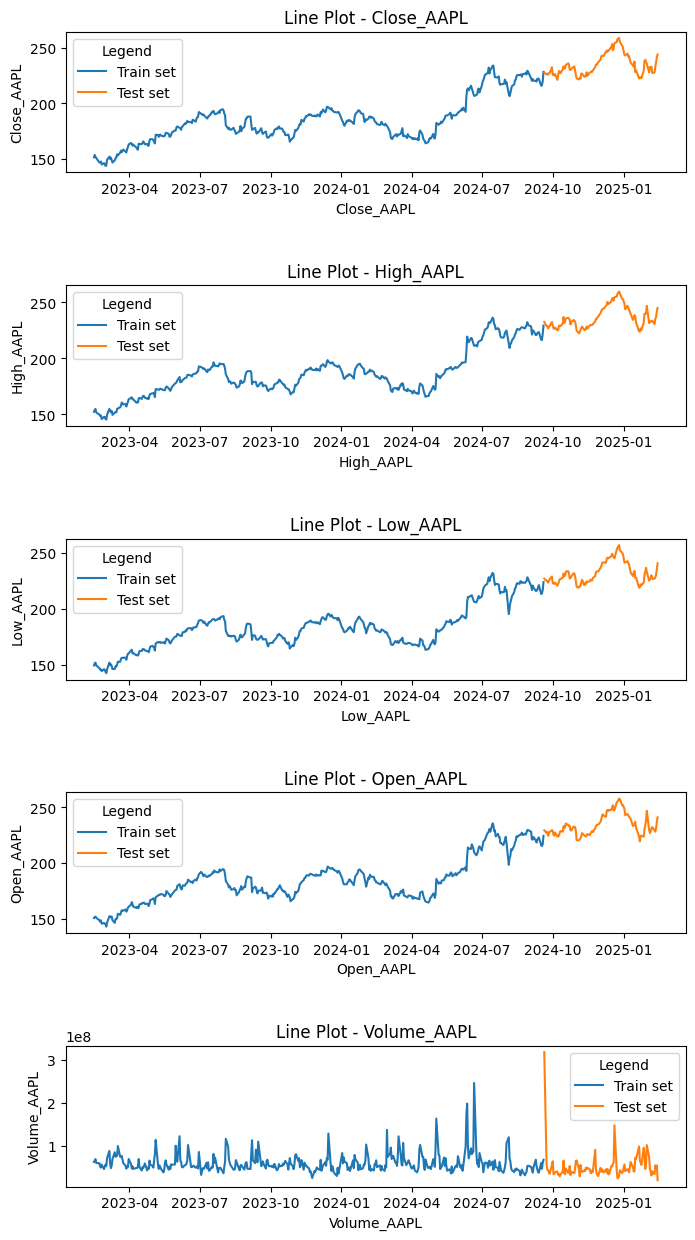

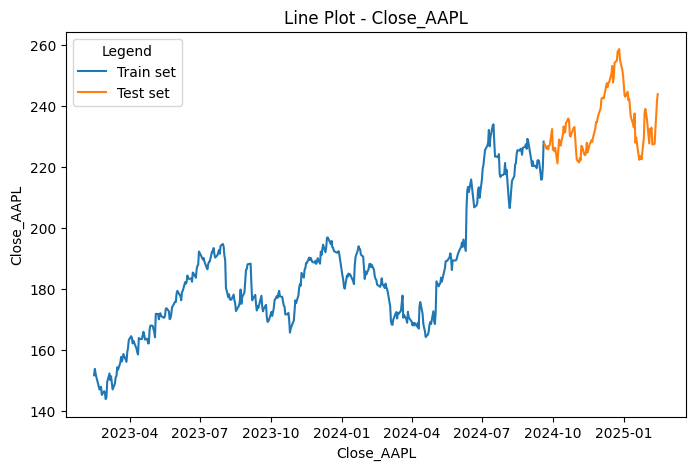

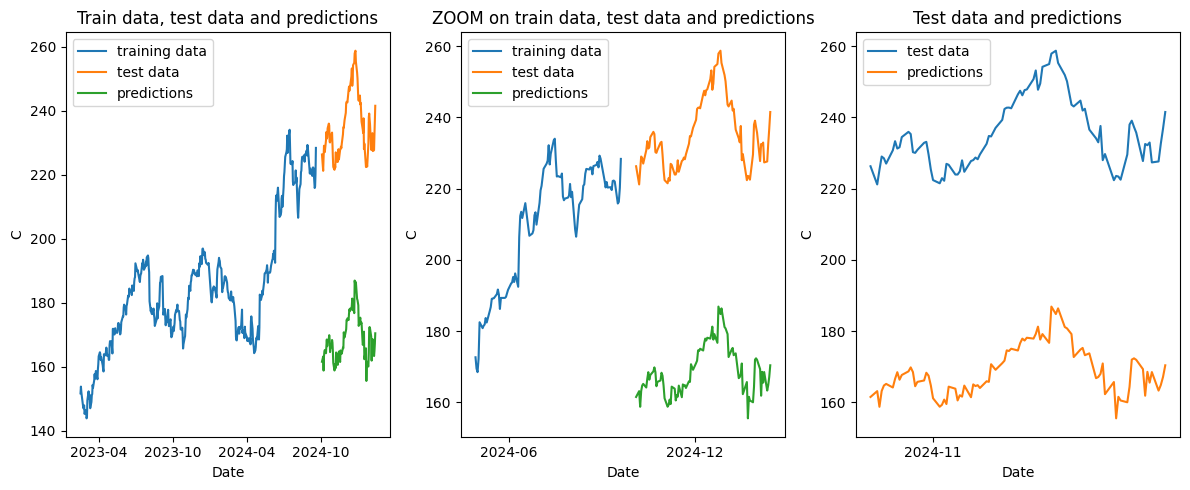

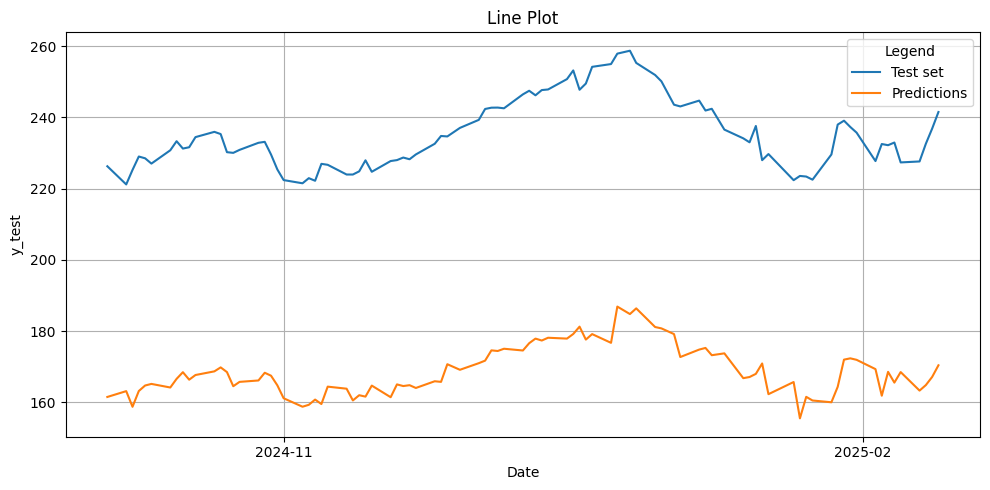

In [24]:
%%time

# Retrieve stock data based on ticker and store it locally
ticker='AAPL'
path_ticker = f"../data/raw_data/{ticker}.csv"

df = load_stock_data_locally(path_ticker)
display(df.head())

print("✅ Data has been loaded.")

# Get the train set and the test set 
train, test = get_split_data(df, train_size = 0.8)  

print(f"train set shape : {train.shape}")
print(f"test set shape : {test.shape}")

print("✅ Train set and test set have been created.")

# Plot the train set and the test set
plot_train_test_df(train, test)

# Plot the train set and the test set (only plot the target feature)
target = f"Close_{ticker}"
plot_lines_series_train_test(train,test, target)  

# Parameters 
scaler = MinMaxScaler() #Scaler
target_scaler = MinMaxScaler()
look_back = 10 # Observation window
features_list = df.columns.to_list() #Features to take into account for prediction
nb_feature = len(features_list) #Number of features (to feed to LSTM model)

print("✅ Parameters have been defined.")

# Prepare train data
X_train_scaled, y_train_scaled, fitted_scaler, fitted_target_scaler = prepare_train_data_multiple_feats(train, 
                                                                               features_list,
                                                                               target, 
                                                                               scaler, 
                                                                               target_scaler, 
                                                                               look_back)
print(f"X_train_scaled shape : {X_train_scaled.shape}")
print(f"y_train_scaled shape : {y_train_scaled.shape}")

print("✅ X_train_scaled, y_train_scaled, fitted_scaler and fitted_target_scaler have been created.")

# Prepare test data
X_test_scaled, y_test_scaled, test_dates = prepare_test_data_multiple_feats(test,
                                                                            features_list,
                                                                            target, 
                                                                            fitted_scaler,
                                                                            look_back)
print(f"X_test_scaled shape : {X_test_scaled.shape}")
print(f"y_test_scaled shape : {y_test_scaled.shape}")

print("✅ X_test_scaled, y_test_scaled, and test_dates have been created.")

#Create model     
lstm_model = define_LSTM_model_max_correlation(look_back, nb_feature)

print("✅ LSTM model has been created.")

# Fit model
lstm_model = fit_lstm_model(lstm_model, X_train_scaled, y_train_scaled)

print("✅ LSTM model has been fitted.")

#Make predictions
y_pred_df = make_predictions(lstm_model, fitted_target_scaler, test_dates)
# display(y_pred_df.head())

print("✅ y_pred_df has been created.")

# Compute y_test
y_test_df = compute_y_test(y_test_scaled, fitted_target_scaler, test_dates)
# display(y_test_df.head(5))

print("✅ y_test_df has been created.")

# Plotting     
plot_final_lstm_3windows(train[target], "training data",
                         y_test_df, "test data",
                         y_pred_df, "predictions",
                         target)

print("✅ Train set, test set and predictions have been plotted.")

# Plot predictions and unseen data (test)
plot_lines_series_pred_test(y_pred_df, y_test_df) 

print("✅ Test set and predictions have been plotted.")

# # Plot derivatives of predictions and unseen data (test)
# plot_lines_series_pred_test(y_pred_df.diff(1).dropna(), y_test_df.diff(1).dropna()) 

# Compute metrics
metrics_df = compute_metrics_df(y_pred_df, y_test_df)
display(metrics_df)

print("✅ Metrics have been computed.")

# merge y_pred and y_test
corr_df = merge_dataframes_on_index(y_test_df,y_pred_df)
# create_correlation_heatmap(corr_df)
display(create_correlation_df(corr_df))

print("✅ Correlation df has been computed.")